# 📩 **Email spam classification using NLP**

## 📚 **Importing all necessary libraries**

In [365]:
import os
import pandas as pd

import email 
from email import policy
from email.parser import BytesParser
import re

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

## 📂 **Creating the dataframe**

In [366]:
# Path to the dataset folder
dataset_folder = 'dataset'

# Initialize an empty list to store the data
data = []

# Iterate through each subdirectory (spam, hard_ham, easy_ham)
for folder_name in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder_name)
    
    # Determine the label based on the folder name
    if folder_name == 'spam':
        label = 'SPAM'
    else:
        label = 'HAM'
    
    # Iterate through each file in the subdirectory
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Read the content of the file
        with open(file_path, 'r', encoding='latin-1') as file:
            content = file.read()
        
        # Append the label and content to the data list
        data.append({'Label': label, 'Content': content})


# Create a DataFrame from the collected data
df_unshuffled = pd.DataFrame(data)
# Display the rows
print("Dataframe:\n\n",df_unshuffled)

df = df_unshuffled.sample(frac=1).reset_index(drop=True)

print("\nSchuffled Dataframe :\n\n",df)

Dataframe:

      Label                                            Content
0      HAM  From exmh-workers-admin@redhat.com  Thu Aug 22...
1      HAM  From Steve_Burt@cursor-system.com  Thu Aug 22 ...
2      HAM  From timc@2ubh.com  Thu Aug 22 13:52:59 2002\n...
3      HAM  From irregulars-admin@tb.tf  Thu Aug 22 14:23:...
4      HAM  From exmh-users-admin@redhat.com  Thu Aug 22 1...
...    ...                                                ...
4193  SPAM  From tba@insiq.us  Wed Dec  4 11:46:34 2002\nR...
4194  SPAM  Return-Path: <raye@yahoo.lv>\nReceived: from u...
4195  SPAM  From cweqx@dialix.oz.au  Tue Aug  6 11:03:54 2...
4196  SPAM  From ilug-admin@linux.ie  Wed Dec  4 11:52:36 ...
4197  SPAM  mv 00001.317e78fa8ee2f54cd4890fdc09ba8176 0000...

[4198 rows x 2 columns]

Schuffled Dataframe :

      Label                                            Content
0      HAM  From fork-admin@xent.com  Mon Sep  9 19:28:00 ...
1     SPAM  From pitster267540871@hotmail.com  Fri Jul 19 ...
2      

## 🧹**Data cleaning** 

In [367]:
# Regex patterns to extract metadata
metadata_patterns = {
    'From': r"^From: (.*)$",
    'To': r"^To: (.*)$",
    'Subject': r"^Subject: (.*)$",
    'Date': r"^Date: (.*)$",
    
}

def parse_email(raw_email):
    # Parse email metadata
    metadata = {}
    for key, pattern in metadata_patterns.items():
        match = re.search(pattern, raw_email, re.MULTILINE)
        if match:
            metadata[key] = match.group(1)

    # Extract email body
    email_body_start = raw_email.find('\n\n') + 2
    body = raw_email[email_body_start:]

    return metadata, body


# Replace 'Content' with the appropriate column name if it's different

# Apply the parse_email function to each row in the DataFrame
parsed_data = df['Content'].apply(parse_email)

# Create a new DataFrame from the parsed email data
parsed_df = pd.DataFrame(parsed_data.tolist(), columns=['Metadata', 'Body'])
parsed_df.head()

,Metadata,Body
0,{'From': 'Rodent of Unusual Size <Ken.Coar@Gol...,Chris Haun wrote:\n> \n> We would need someone...
1,"{'From': '""NELL"" <pitster267540871@hotmail.com...","Dear Computer User jm8675309 ,\n\n<html>\n<bod..."
2,"{'From': 'Stephen Liu <satimis@writeme.com>', ...","Hi All Folks,\n\nI have 'APT' installed and up..."
3,"{'From': 'guardian <rssfeeds@example.com>', 'T...","URL: http://www.newsisfree.com/click/-3,868897..."
4,"{'From': 'Brent Welch <welch@panasas.com>', 'T...","If you haven't already, you should enable the ..."


In [368]:
# Remove the date from the body
parsed_df['Body'] = parsed_df['Body'].apply(lambda x: re.sub(r"^Date: .*", "", x, flags=re.MULTILINE))

parsed_df.head()

,Metadata,Body
0,{'From': 'Rodent of Unusual Size <Ken.Coar@Gol...,Chris Haun wrote:\n> \n> We would need someone...
1,"{'From': '""NELL"" <pitster267540871@hotmail.com...","Dear Computer User jm8675309 ,\n\n<html>\n<bod..."
2,"{'From': 'Stephen Liu <satimis@writeme.com>', ...","Hi All Folks,\n\nI have 'APT' installed and up..."
3,"{'From': 'guardian <rssfeeds@example.com>', 'T...","URL: http://www.newsisfree.com/click/-3,868897..."
4,"{'From': 'Brent Welch <welch@panasas.com>', 'T...","If you haven't already, you should enable the ..."


In [369]:

def remove_special_characters(text):
    # Define a regular expression pattern to match special characters
    pattern = r'[^a-zA-Z0-9\s]'  # Matches any character that is not a letter, digit, or whitespace

    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text


def parse_email_body(body):
    # Remove HTML tags
    body = re.sub(r'<[^>]+>', '', body)
    body = re.sub(r'nbsp', '',body)
    # Remove URLs
    body = re.sub(r'http\S+', '', body)
    # Remove special characters and escape sequences
    body = remove_special_characters(body)
    
    return body.strip()

# Apply the parse_email_body function to the 'Body' column of parsed_df
parsed_df['Body'] = parsed_df['Body'].apply(parse_email_body)
parsed_df.head()

,Metadata,Body
0,{'From': 'Rodent of Unusual Size <Ken.Coar@Gol...,Chris Haun wrote\n \n We would need someone to...
1,"{'From': '""NELL"" <pitster267540871@hotmail.com...",Dear Computer User jm8675309 \n\n\n\nYOUR INTE...
2,"{'From': 'Stephen Liu <satimis@writeme.com>', ...",Hi All Folks\n\nI have APT installed and updat...
3,"{'From': 'guardian <rssfeeds@example.com>', 'T...",URL \n\n\nPM calls for major arms deal to save...
4,"{'From': 'Brent Welch <welch@panasas.com>', 'T...",If you havent already you should enable the de...


In [370]:
# Define a function to extract the main body of the email

def extract_main_body(body):
    # Split the body by lines
    lines = body.split('\n')
    main_body_lines = []
    for line in lines:
        if not re.match(r'^[-]+\s*$', line) and not re.match(r'^------------------', line) and not re.match(r'^\s*Yahoo! Groups Sponsor', line) and not re.match(r'^Your use of Yahoo! Groups is subject to', line):
            main_body_lines.append(line)
    # Join the remaining lines to form the main body
    main_body = '\n'.join(main_body_lines)
    return main_body.strip()

# Apply the extract_main_body function to the 'Body' column of parsed_df
parsed_df['Body'] = parsed_df['Body'].apply(extract_main_body)


parsed_df.head()

,Metadata,Body
0,{'From': 'Rodent of Unusual Size <Ken.Coar@Gol...,Chris Haun wrote\n \n We would need someone to...
1,"{'From': '""NELL"" <pitster267540871@hotmail.com...",Dear Computer User jm8675309 \n\n\n\nYOUR INTE...
2,"{'From': 'Stephen Liu <satimis@writeme.com>', ...",Hi All Folks\n\nI have APT installed and updat...
3,"{'From': 'guardian <rssfeeds@example.com>', 'T...",URL \n\n\nPM calls for major arms deal to save...
4,"{'From': 'Brent Welch <welch@panasas.com>', 'T...",If you havent already you should enable the de...


In [371]:
# Concatenate the two DataFrames along the columns axis
merged_df = pd.concat([df, parsed_df], axis=1)
merged_df.head()

,Label,Content,Metadata,Body
0,HAM,From fork-admin@xent.com Mon Sep 9 19:28:00 ...,{'From': 'Rodent of Unusual Size <Ken.Coar@Gol...,Chris Haun wrote\n \n We would need someone to...
1,SPAM,From pitster267540871@hotmail.com Fri Jul 19 ...,"{'From': '""NELL"" <pitster267540871@hotmail.com...",Dear Computer User jm8675309 \n\n\n\nYOUR INTE...
2,HAM,From rpm-list-admin@freshrpms.net Fri Sep 6 ...,"{'From': 'Stephen Liu <satimis@writeme.com>', ...",Hi All Folks\n\nI have APT installed and updat...
3,HAM,From rssfeeds@jmason.org Wed Oct 9 10:52:51 ...,"{'From': 'guardian <rssfeeds@example.com>', 'T...",URL \n\n\nPM calls for major arms deal to save...
4,HAM,From exmh-users-admin@redhat.com Mon Sep 2 2...,"{'From': 'Brent Welch <welch@panasas.com>', 'T...",If you havent already you should enable the de...


In [372]:
# Drop the 'Metadata' and 'Content' columns from the DataFrame
merged_df = merged_df.drop(columns=['Metadata', 'Content'])
merged_df.head()

,Label,Body
0,HAM,Chris Haun wrote\n \n We would need someone to...
1,SPAM,Dear Computer User jm8675309 \n\n\n\nYOUR INTE...
2,HAM,Hi All Folks\n\nI have APT installed and updat...
3,HAM,URL \n\n\nPM calls for major arms deal to save...
4,HAM,If you havent already you should enable the de...


In [373]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4198 entries, 0 to 4197
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4198 non-null   object
 1   Body    4198 non-null   object
dtypes: object(2)
memory usage: 65.7+ KB


## 📊 **Data Visualization**

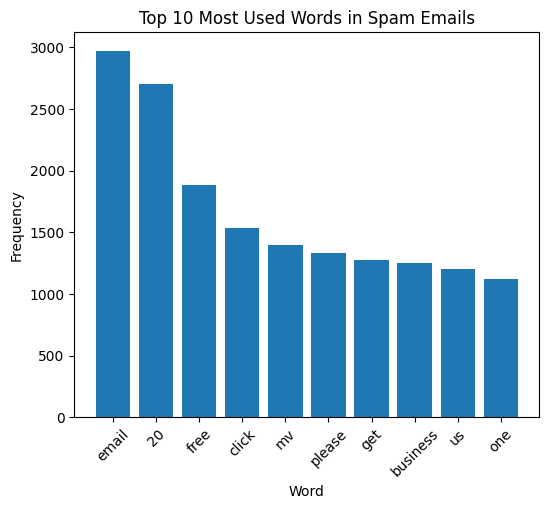

In [374]:
# Filter the DataFrame to include only spam emails
spam_df = merged_df[merged_df['Label'] == 'SPAM']

# Tokenize the text in the 'Body' column
tokens = []
for text in spam_df['Body']:
    tokens.extend(word_tokenize(text.lower()))  # Convert to lowercase



# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [token for token in tokens if token not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_tokens)

# Get most common words and their frequencies
top_words = word_counts.most_common(10)  

words, frequencies = zip(*top_words)

# Plot the most common words
plt.figure(figsize=(6, 5))
plt.bar(words, frequencies)
plt.title('Top 10 Most Used Words in Spam Emails')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Note :
- mv is short for Market Value

## 🔎 **Data Processing**

In [375]:
# Encoding the Label feature 
merged_df.loc[merged_df['Label'] == 'SPAM', 'Label'] = 0
merged_df.loc[merged_df['Label'] == 'HAM', 'Label'] = 1
merged_df.head()

,Label,Body
0,1,Chris Haun wrote\n \n We would need someone to...
1,0,Dear Computer User jm8675309 \n\n\n\nYOUR INTE...
2,1,Hi All Folks\n\nI have APT installed and updat...
3,1,URL \n\n\nPM calls for major arms deal to save...
4,1,If you havent already you should enable the de...


### Spliting the data into training and testing data

In [376]:
x = merged_df['Body']
y = merged_df['Label']

In [377]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

### Transform the text data to feature vectors to be used as input

In [378]:
#Feature extraction
feature_extraction = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
# Fit the vectorizer on the training data and transform both training and testing data
x_train_features = feature_extraction.fit_transform(x_train)
x_test_features = feature_extraction.transform(x_test)

In [379]:
# convert y_train and y_test values into integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [380]:
print(x_train)

964     URL \n\n\nRael is plagued by MSIE instability ...
239     Dear flatware\n\nIm about to undertake a massi...
2387    URL e59c6ca5938fc27a6995e30fc10b6482\n\n\nIt c...
990     Specialized Acquired EMail Addresses\n\n\n \n\...
108     Yes  great minds think alike But even withput ...
                              ...                        
3444    NextPart00000E661E42E2BC1032A62\nContentType t...
466     On Saturday 28 September 2002 0437 pm you stru...
3092    This is an automated response to a message you...
3772    URL \n\n\nBusiness The longawaited recovery in...
860     Shopping f\nor a loan \n      has never been e...
Name: Body, Length: 3358, dtype: object


In [381]:
print(x_train_features)

  (0, 36972)	0.09644396154286436
  (0, 57199)	0.14890940648216386
  (0, 16045)	0.18804616409450875
  (0, 57371)	0.07763146620446566
  (0, 48599)	0.14772297436557624
  (0, 34174)	0.11987675235146195
  (0, 30091)	0.18804616409450875
  (0, 41585)	0.1826199746074386
  (0, 42528)	0.11076531872831352
  (0, 47710)	0.16832674586321716
  (0, 21514)	0.08281569315060493
  (0, 41766)	0.1711908800318714
  (0, 57082)	0.16344702959238247
  (0, 51356)	0.12387211535594733
  (0, 56477)	0.14072739941858467
  (0, 39034)	0.14551081047550304
  (0, 24946)	0.09561489142154724
  (0, 27954)	0.08111125438915988
  (0, 59839)	0.08720110784810202
  (0, 14354)	0.1528613849350342
  (0, 1747)	0.1276206027909509
  (0, 2287)	0.15938476961384965
  (0, 46236)	0.15938476961384965
  (0, 44177)	0.1465917455297451
  (0, 33042)	0.10723492275276213
  :	:
  (3357, 19835)	0.15774137374685193
  (3357, 38920)	0.24093949961285357
  (3357, 47314)	0.2703798192232696
  (3357, 51019)	0.11787724276965643
  (3357, 46308)	0.116803783172303

## 🤖 **Model training**

#### **LogisticRegression**

In [382]:
mailModel = LogisticRegression()

In [383]:
mailModel.fit(x_train_features, y_train)

LogisticRegression()

#### **Naive Bayes**

In [384]:
# store data as a matrix
cv= CountVectorizer()

x_train_count=cv.fit_transform(x_train.values)
x_test_count =cv.transform(x_test.values)

x_test_count.toarray()
x_train_count.toarray()

bModel=MultinomialNB()
#train
bModel.fit(x_train_count,y_train)

MultinomialNB()

## 📍 **Evaluationg the model's accuracy**

#### **LogisticRegression**

In [385]:
# Training Accuracy
prediction_training_data = mailModel.predict(x_train_features)
accuracy_training_data = accuracy_score(y_train, prediction_training_data)
print(accuracy_training_data)

0.9749851101846337


In [386]:
# Testing Accuracy
prediction_test_data = mailModel.predict(x_test_features)
accuracy_training_data = accuracy_score(y_test, prediction_test_data)
print(accuracy_training_data)

0.9785714285714285


#### **Naive Bayes**

In [387]:
# Training Accuracy
prediction_training_data = bModel.predict(x_train_count)
accuracy_training_data = accuracy_score(y_train, prediction_training_data)
print(accuracy_training_data)

0.9940440738534843


In [388]:
# Testing Accuracy
prediction_test_data = bModel.predict(x_test_count)
accuracy_test_data = accuracy_score(y_test, prediction_test_data)
print(accuracy_test_data)

0.9845238095238096


- Ensuring that the Naive Bayes model is not overfitting 

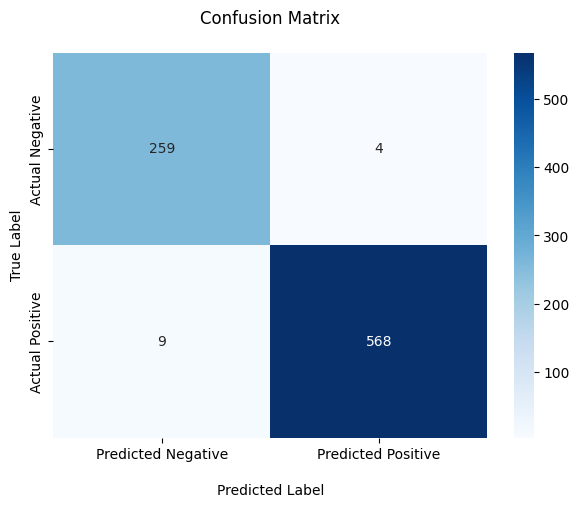

In [389]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, prediction_test_data)

# Visualize
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('\nPredicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix\n')
plt.show()

## ✅ **Model Testing**

#### **LogisticRegression**

In [390]:
y_pred = mailModel.predict(x_test_features)

num_rows = 10

# Combine predicted and actual values for comparison
results = zip(y_pred[:num_rows], y_test[:num_rows])

# Print predicted and actual values
print("------ Values ------")
print("Predicted | Actual")
for pred, actual in results:
    print(f"{pred}         | {actual}")

------ Values ------
Predicted | Actual
1         | 1
1         | 1
1         | 1
0         | 0
1         | 1
1         | 1
0         | 0
0         | 0
0         | 0
0         | 0


In [391]:
# Enter an email you wanna test !
input_your_email = ["You won a free car !!  Click the link : http.freecars.com "]
input_data_features = feature_extraction.transform(input_your_email)
prediction = mailModel.predict(input_data_features)
print("Result :")
if(prediction==1):
    print('Ham mail')
else:
    print('Spam mail')

Result :
Spam mail


#### **Naive Bayes**

In [392]:
# preTest HAM
email_ham =["Hi don't forget the meeting tomorrow 9am !"]
email_ham_count=cv.transform(email_ham)
bModel.predict(email_ham_count)

array([1])

In [393]:
# preTest SPAM
email_spam =["Please Join us and get 20 000$ to start your buisness !"]
email_spam_count=cv.transform(email_spam)
bModel.predict(email_spam_count)

array([0])

In [394]:
bModel.score(x_test_count,y_test)

0.9845238095238096